In [46]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import doc_provenance
parent_directory = str(Path().resolve().parent)
parent_directory

import os,sys 
script_path = os.path.abspath("../src")  # Adjust the path
sys.path.append(script_path)
print(parent_directory)

/Users/yiminglin/Documents/Codebase/doc-provenance


In [48]:
import json 
import tiktoken

def read_json(path):
    if not os.path.exists(path):
        print('File not found!', path)
        return None
    with open(path, "r", encoding="utf-8") as file:
        data = json.load(file)
    return data

def count_tokens(text, model="gpt-4o-mini"):
    encoder = tiktoken.encoding_for_model(model)  # Get the tokenizer for the specific model
    tokens = encoder.encode(text)  # Encode text into tokens
    return len(tokens)

def write_json_to_file(filename, data):
    with open(filename, "w") as f:
        json.dump(data, f, indent=4)

import statistics

def find_substantially_large(values, factor=2):
    """
    Find and return the values in the list that are substantially larger than the average.
    
    A value is considered substantially large if it is greater than:
        mean + (factor * standard deviation)
    
    Parameters:
        values (list of numbers): The list of values to analyze.
        factor (float): The number of standard deviations above the mean 
                        that a value must be to be considered substantially large.
                        Default is 2.
    
    Returns:
        list: A list of values that exceed the threshold.
    """
    if not values:
        return [], 0 
    
    mean = statistics.mean(values)
    stdev = statistics.stdev(values)
    threshold = mean + factor * stdev
    return [v for v in values if v > threshold], mean



In [55]:
def get_results(data_path, result_folder_path, sufficient_provenance_strategy, minimal_provenance_strategy, dataset, vanilla_ratio = 1):
    objects = read_json(data_path)
    results = {}
    strategy = sufficient_provenance_strategy + '_' + minimal_provenance_strategy
    i = 0
    num_case = 500
    time_list = []
    cost_list = []
    time_bound = 250
    for o in objects:
        i += 1
        if dataset == 'hotpotQA':
            title = o['document_name']
        else:
            title = o['id']
        
        result_path = result_folder_path + str(i) + '_' + str(title) + '_'  + strategy + '.json'
        if not os.path.exists(result_path):
            # if i < num_case:
            #     print('path not exist:', result_path)
            continue
        result = read_json(result_path)
        if 'tokens' not in result:
            # if i < num_case:
            #     print('result not exist:', result_path)
            continue

        sufficient_strategy = sufficient_provenance_strategy + '_null'
        sufficient_result_path = result_folder_path + str(i) + '_' + str(title) + '_'  + sufficient_strategy + '.json'
        sufficient_result = read_json(sufficient_result_path)

        #print(result_path)

        r = {}
        #print(i, strategy)
        r['document_size'] = result['document_size']
        r['provenance_size'] = result['provenance_size']
        r['time'] = result['time'] * vanilla_ratio
        r['tokens'] = (result['tokens'][0] * vanilla_ratio, result['tokens'][1] * vanilla_ratio)
        if minimal_provenance_strategy == 'null':
            r['minimal_provenance_sentence_size'] = 0
        else: 
            r['minimal_provenance_sentence_size'] = len(result['provenance_ids'])
        r['minimal_provenance'] = result['provenance_ids']

        if 'provenance_ids' not in sufficient_result:
            continue
        r['sufficient_provenance_sentence_size'] = len(sufficient_result['provenance_ids'])
        r['sufficient_provenance'] = sufficient_result['provenance_ids']
        time_list.append(r['time'])
        cost_list.append(r['tokens'][0] + r['tokens'][1])
        results[i] = r

    #print('time, cost size:', len(time_list), len(cost_list))

    time_large_vals, time_mean = find_substantially_large(time_list)
    cost_large_vals, cost_mean = find_substantially_large(cost_list) 

    updated_results = {}
    for rid, result in results.items():
        time = result['time']
        cost = result['tokens'][0] + result['tokens'][1]
        if time in time_large_vals or time  >time_bound:
            continue
        if cost in cost_large_vals:
            continue
        updated_results[rid] = result 


    return updated_results    

def get_aggregate_results(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, data_path, result_folder_path, dataset, vanilla_ratio = 1): 
    #print(vanilla_ratio)
    size_ratios = {}
    large_case_ids = {}
    medium_case_ids = {}
    provenance_size_dict = {}
    size_ratio_dict = {}
    time_dict = {}
    cost_dict = {}
    document_size_dict = {}
    time_distribution = {}
    cost_distribution = {}
    sufficient_provenance_sentence_sizes = {}
    minimal_provenance_sentence_sizes = {}
    out = {}

    for sufficient_provenance_strategy in sufficient_provenance_strategy_pool:
        for minimal_provenance_strategy in minimal_provenance_strategy_pool:
            strategy = sufficient_provenance_strategy + '_' + minimal_provenance_strategy
            # if minimal_provenance_strategy != 'null':
            #     continue
            print(strategy)
            results = get_results(data_path, result_folder_path, sufficient_provenance_strategy, minimal_provenance_strategy, dataset, vanilla_ratio = vanilla_ratio)
            out[strategy] = results 
            #print('len of results:', len(results))
            avg_provenance_size = 0
            avg_size_ratio = 0
            avg_time = 0
            avg_in_tokens = 0
            avg_out_tokens = 0
            avg_document_size = 0
            avg_sufficient_provenance_sentence_size = 0
            avg_minimal_provenance_sentence_size = 0
            avg_provenance_sentence_size_ratio = 0

            size_ratio_list = []
            large_case_id = []
            medium_case_id = []
            sufficient_provenance_sentence_size_list = []
            minimal_provenance_sentence_size_list = []
            time_list = []
            cost_list = []
            cnt = 0
            for rid, result in results.items():
                size_ratio = result['provenance_size']/result['document_size']
                provenance_size = result['provenance_size']
                time = result['time']
                in_tokens = result['tokens'][0]
                out_tokens = result['tokens'][1] 
                document_size = result['document_size']
                sufficient_provenance_sentence_size = result['sufficient_provenance_sentence_size']
                minimal_provenance_sentence_size = result['minimal_provenance_sentence_size']

                avg_provenance_size += provenance_size
                avg_size_ratio += size_ratio
                avg_time += time 
                avg_in_tokens += in_tokens 
                avg_out_tokens += out_tokens 
                avg_document_size += document_size
                avg_sufficient_provenance_sentence_size += sufficient_provenance_sentence_size
                avg_minimal_provenance_sentence_size += minimal_provenance_sentence_size
                avg_provenance_sentence_size_ratio += minimal_provenance_sentence_size / sufficient_provenance_sentence_size
                cnt += 1

                tokens = (in_tokens + out_tokens) 

                size_ratio_list.append(size_ratio)
                time_list.append(time)
                cost_list.append(tokens)
                sufficient_provenance_sentence_size_list.append(sufficient_provenance_sentence_size)
                minimal_provenance_sentence_size_list.append(minimal_provenance_sentence_size)

            avg_provenance_size /= cnt
            avg_size_ratio /= cnt
            avg_time /= cnt
            avg_in_tokens /= cnt
            avg_out_tokens /= cnt
            avg_document_size /= cnt
            avg_sufficient_provenance_sentence_size /= cnt
            avg_minimal_provenance_sentence_size /= cnt 
            avg_provenance_sentence_size_ratio /= cnt 
            print('provenance_size, size_ratio:', avg_provenance_size, avg_size_ratio)
            print('time:', avg_time)
            print('tokens:', avg_in_tokens, avg_out_tokens)
            #print('sufficient provenance sentence size, minimal provenance sentence size, ratio', avg_sufficient_provenance_sentence_size, avg_minimal_provenance_sentence_size, avg_provenance_sentence_size_ratio)
            print('')
            size_ratios[strategy] = size_ratio_list
            time_distribution[strategy] = time_list
            cost_distribution[strategy] = cost_list 
            large_case_ids[strategy] = large_case_id
            medium_case_ids[strategy] = medium_case_id
            sufficient_provenance_sentence_sizes[strategy] = sufficient_provenance_sentence_size_list
            minimal_provenance_sentence_sizes[strategy] = minimal_provenance_sentence_size_list

            provenance_size_dict[strategy] = avg_provenance_size
            size_ratio_dict[strategy] = avg_size_ratio
            time_dict[strategy] = avg_time
            cost_dict[strategy] = avg_in_tokens + avg_out_tokens
            document_size_dict[strategy] = avg_document_size

    out_path = '/Users/yiminglin/Documents/Codebase/doc-provenance/tests/gpt4omini_' + dataset + '.json'
    write_json_to_file(out_path, out) 

    return size_ratios, provenance_size_dict, size_ratio_dict, time_dict, cost_dict, document_size_dict, time_distribution, cost_distribution, sufficient_provenance_sentence_sizes, minimal_provenance_sentence_sizes

def plot_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, size_ratios):
    # Prepare your strategies
    plots = []
    titles = []

    for sufficient_provenance_strategy in sufficient_provenance_strategy_pool:
        for minimal_provenance_strategy in minimal_provenance_strategy_pool:
            # if minimal_provenance_strategy != 'null':
            #     continue
            strategy = sufficient_provenance_strategy + '_' + minimal_provenance_strategy
            print(strategy)
            a = size_ratios[strategy]
            q1, medium, q3, avg = get_stats(a) 
            print('25%:', q1, '50%:', medium, '75%:', q3, 'average:', avg) 
            plots.append(a)
            titles.append(strategy)

    # Set up subplots
    n = len(plots)
    cols = 3  # adjust columns as needed
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    for i, (a, title) in enumerate(zip(plots, titles)):
        counts, bins, _ = axes[i].hist(a, bins='auto', edgecolor='black')
        total = counts.sum()
        percentages = (counts / total) * 100

        # Clear and re-plot using percentages
        axes[i].cla()
        axes[i].bar(bins[:-1], percentages, width=np.diff(bins), align='edge', edgecolor='black')
        axes[i].set_title(f'{title}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency (Percentage)')
        axes[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))

    # Hide any extra subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def plot_table(provenance_size_dict, size_ratio_dict, time_dict, cost_dict):
        format_dict = lambda d: {k: f"{v:.2f}" for k, v in d.items()}

        form_provenance_size_dict = format_dict(provenance_size_dict)
        form_size_ratio_dict = format_dict(size_ratio_dict)
        form_time_dict = format_dict(time_dict)
        form_cost_dict = format_dict(cost_dict)

        df = pd.DataFrame({'Provenance Size (Tokens)': form_provenance_size_dict, 'Provenance Size Ratio': form_size_ratio_dict, 'Latency': form_time_dict, 'Used Tokens': form_cost_dict})
        # Plot the table with larger size
        fig, ax = plt.subplots(figsize=(8, len(df)*0.6 + 1))  # Adjust height based on number of rows
        ax.axis('tight')
        ax.axis('off')

        table = ax.table(cellText=df.values,
                        rowLabels=df.index,
                        colLabels=df.columns,
                        cellLoc='center',
                        loc='center')

        # Increase font size
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 1.2)  # scale width, height

        try:
            table.auto_set_column_width(col=list(range(len(df.columns) + 1)))  # +1 for row labels
        except AttributeError:
            print("auto_set_column_width not available — upgrade matplotlib to >=3.4 for best effect.")


        plt.show()

def get_stats(data):
    arr = np.array(data)

    # Calculate percentiles
    q1 = np.percentile(arr, 25)
    median = np.percentile(arr, 50)
    q3 = np.percentile(arr, 75)
    average = np.mean(arr)

    return q1, median, q3, average 



In [56]:
#stack bar for top-1

import matplotlib.pyplot as plt
import numpy as np
# Add custom legend using strategy_colors
from matplotlib.patches import Patch

def is_prefix(prefix, string):
    return string.startswith(prefix)

def stack_bar(time_dict, cost_dict, type, y_label,y1,y2): 
    stack_dict = {}
    raw_dict = {}
    if type == 'cost':
        raw_dict = cost_dict
    else:
        raw_dict = time_dict

    for s1, l1 in raw_dict.items():
        if 'null' in s1:
            strategy_prefix = s1[:-5]
            if s1 not in stack_dict: 
                stack_dict[s1] = l1
        for s2, l2 in raw_dict.items():
            if s1 == s2:
                continue
            if is_prefix(strategy_prefix, s2) and s2 not in stack_dict: 
                stack_dict[s2] = l2-l1 

    bars = []
    strategy_pairs = []
    strategies = []
    for s,l in stack_dict.items():
        #print(s)
        if 'null' not in s:
            continue
        s_prefix = s[:-5]
        s_eg = s_prefix + '_exponential_greedy'
        bars.append((l, stack_dict[s_eg]))
        ss = s_prefix.replace("_sufficient", "")
        strategy_pairs.append((ss,'exponential_greedy'))

        s_sg = s_prefix + '_sequential_greedy'
        bars.append((l, stack_dict[s_sg]))
        strategy_pairs.append((ss,'sequential_greedy'))

        strategies.append(ss)
        strategies.append('exponential_greedy')
        strategies.append('sequential_greedy')

    strategies = list(set(strategies))
    #print(strategies)

    #print(len(bars))
    #print(strategy_pairs)
    import matplotlib.pyplot as plt
    import numpy as np
    # Add custom legend using strategy_colors
    from matplotlib.patches import Patch

    strategy_colors = {
        "exponential_greedy": "green",
        "sequential_greedy": "blue",
        "LLM_score_top_down": "purple",
        "embedding_top_down": "orange",
        "embedding_bottem_up": "red",
        "LLM_score_bottem_up": "yellow",
        "divide_and_conquer": "pink"
    }
    num_bars = len(bars)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(num_bars)
    strategy_labels = []
    for i, ((v1, v2), (s1, s2)) in enumerate(zip(bars, strategy_pairs)):
        ax.bar(x[i], v1, color=strategy_colors[s1], label=s1 if i == 0 or s1 not in strategy_pairs[:i] else "")
        ax.bar(x[i], v2, bottom=v1, color=strategy_colors[s2], label=s2 if i == 0 or s2 not in strategy_pairs[:i] else "")
        strategy_labels.append(s1 + '_' + s2)

    # Add labels and legend
    ax.set_ylabel(y_label)
    if y1 != -1:
        ax.set_ylim(y1,y2)
    ax.set_title('Stacked Bar Graph by Strategy')
    ax.set_xticks([])

    #ax.set_xticks(x)
    #ax.set_xticklabels([f"{i}" for i in strategy_labels], rotation=45)
    legend_handles = [Patch(facecolor=color, label=strategy) for strategy, color in strategy_colors.items()]
    ax.legend(handles=legend_handles, title="Strategy", loc='best', ncol = 2)

    plt.tight_layout()
    plt.show()

def bar_provenance_ratio(size_ratio_dict,y1,y2):

    # Your custom group names
    group_names = ['LLM_score_sufficient_bottem_up', 'LLM_score_sufficient_top_down', 'embedding_sufficient_bottem_up', 'embedding_sufficient_top_down', 'divide_and_conquer_sufficient']

    result = []
    for group in group_names:
        vals = [
            size_ratio_dict.get(f"{group}_null"),
            size_ratio_dict.get(f"{group}_exponential_greedy"),
            size_ratio_dict.get(f"{group}_sequential_greedy")
        ]
        result.append(vals)

    #print(result)
    data = np.array(result)

    n_groups = data.shape[0]
    n_bars = data.shape[1]
    colors = ['blue', 'red', 'green']
    bar_width = 0.2
    x = np.arange(n_groups)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))

    for i in range(n_bars):
        if i == 0:
            label = 'sufficient'
        elif i == 1:
            label = 'sufficient+exponential'
        else:
            label = 'sufficient+sequential'
        ax.bar(x + i * bar_width, data[:, i], width=bar_width, color=colors[i], label=label)

    ax.set_ylabel('Provenance Size Ratio')
    if y1 != -1:
        ax.set_ylim(y1,y2)
    ax.set_title('Grouped Bar Chart with Custom Names')
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(group_names, rotation=45)
    ax.legend(loc = 'best')

    plt.show()



In [64]:
#nl_dev  

model_name = 'gpt4omini'
dataset = 'nl_dev'

sufficient_provenance_strategy_pool = ['LLM_score_sufficient_bottem_up','LLM_score_sufficient_top_down', 'embedding_sufficient_bottem_up','embedding_sufficient_top_down', 'divide_and_conquer_sufficient']
minimal_provenance_strategy_pool = ['null','exponential_greedy','sequential_greedy']
#minimal + relevance score 
#size, cost lantecy pics..
data_path = parent_directory + '/data/natural-questions_nq-dev-full.json'
result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/' + model_name + '/eval' + '/nl_dev/results_minimal/'

size_ratios, provenance_size_dict, size_ratio_dict, time_dict, cost_dict, document_size_dict, time_distribution, cost_distribution, sufficient_provenance_sentence_sizes, minimal_provenance_sentence_sizes = get_aggregate_results(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, data_path, result_folder_path,dataset, vanilla_ratio = 1)


                

LLM_score_sufficient_bottem_up_null
provenance_size, size_ratio: 967.1205211726384 0.14779883320405557
time: 2.5396051298135265
tokens: 1621.2247557003257 22.697068403908794

LLM_score_sufficient_bottem_up_exponential_greedy
provenance_size, size_ratio: 217.751677852349 0.04642450488522705
time: 13.1322757165704
tokens: 12452.808724832215 201.46644295302013

LLM_score_sufficient_bottem_up_sequential_greedy
provenance_size, size_ratio: 232.0242214532872 0.04960267933679339
time: 17.215952774232647
tokens: 20399.553633217995 255.03114186851212

LLM_score_sufficient_top_down_null
provenance_size, size_ratio: 1875.1672727272728 0.23741609601230595
time: 3.790302284414118
tokens: 6944.058181818182 38.64363636363636

LLM_score_sufficient_top_down_exponential_greedy
provenance_size, size_ratio: 241.01908396946564 0.0538201072155819
time: 15.282924649369626
tokens: 26916.858778625956 211.1908396946565

LLM_score_sufficient_top_down_sequential_greedy
provenance_size, size_ratio: 240.08139534883

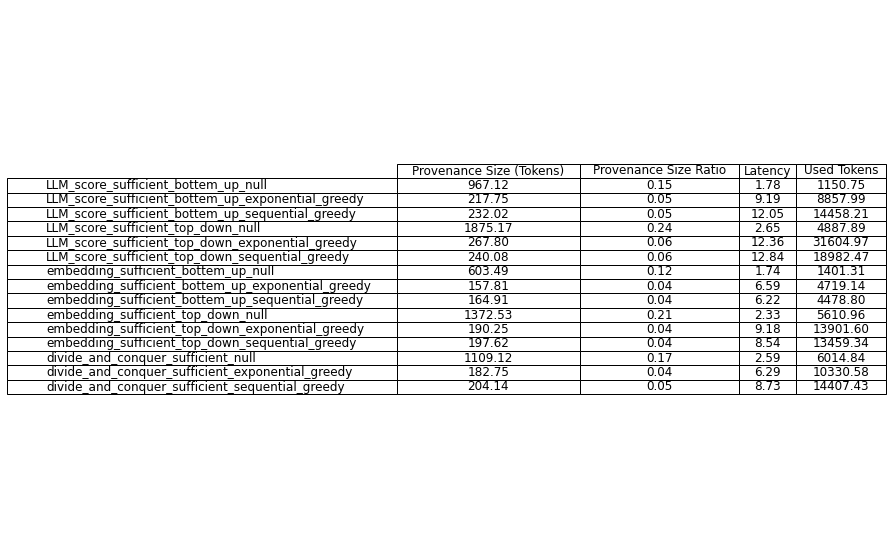

In [60]:

plot_table(provenance_size_dict, size_ratio_dict, time_dict, cost_dict)

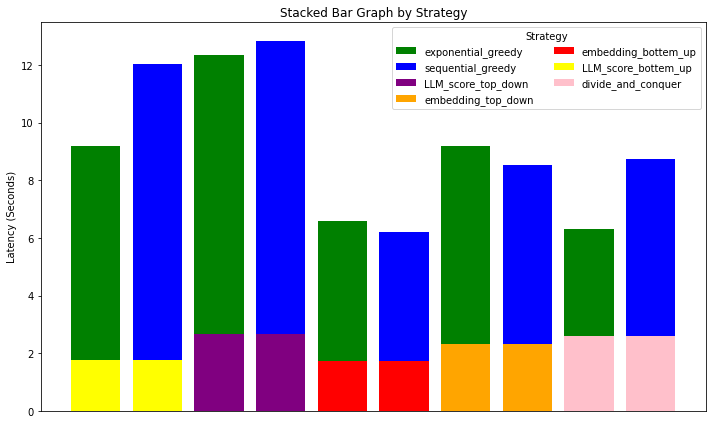

In [36]:
stack_bar(time_dict, cost_dict, 'latency', 'Latency (Seconds)', -1,-1)


7957.53915122845


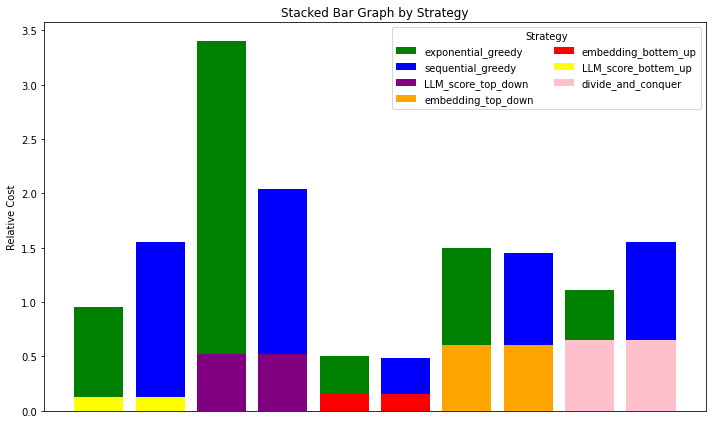

In [29]:
document_size = sum(document_size_dict.values()) / len(document_size_dict)
print(document_size)
cost_dict
relative_cost_dict = cost_dict.copy()

for strategy, cost in relative_cost_dict.items():
    relative_cost_dict[strategy] = cost/document_size 

stack_bar(time_dict, relative_cost_dict, 'cost', 'Relative Cost', -1, -1)




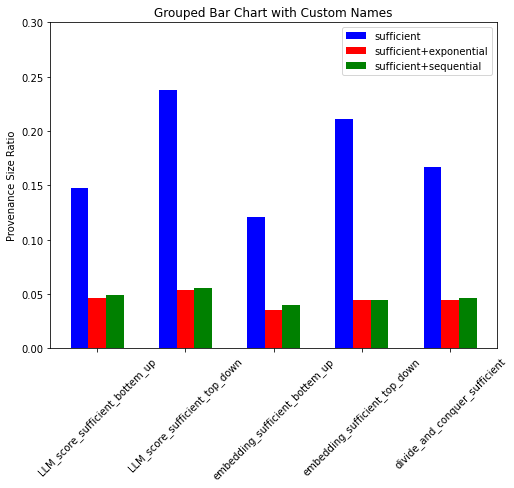

In [26]:
bar_provenance_ratio(size_ratio_dict,0,0.3)

- Bottem-up is better than top-down
  - 9% smaller sufficient provenance size 
  - 134% faster 
  - 25% tokens 
- Exponential vs sequential
  - Exponential is a winner in for most sufficient strategies 
    - 55% tokens for LLM_score_bottem up, to 94% tokens for embedding sufficient bottem up
- Sufficient vs Minimal
  - Provenance size/document size 
    - 15% - 24% size reduction for sufficient
    - ~6% size reduction for minimal
  - Latency
    - Sufficient: ~3 seconds
    - Sufficient + Minimal: 10 - 20 seconds
    - Winners: **Divide_conquer + exponential** and **embedding_bottem_up + exponential** (10 seconds)
  - Cost 
    - Sufficient: 0.2X - 1.1X tokens relative to doc size 
    - Sufficient + Minimal: 1.1X - 5.2X tokens relative to doc size 
    - Winners: **embedding_bottem_up + exponential** (1.1X)

In [65]:
#paper 

model_name = 'gpt4omini'
dataset = 'paper'
sufficient_provenance_strategy_pool = ['LLM_score_sufficient_bottem_up','LLM_score_sufficient_top_down', 'embedding_sufficient_bottem_up','embedding_sufficient_top_down', 'divide_and_conquer_sufficient']
minimal_provenance_strategy_pool = ['null','exponential_greedy','sequential_greedy']

data_path = parent_directory + '/data/qasper_sample_papers.json'
result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/' + model_name + '/eval' + '/' + dataset+ '/results_minimal/'

size_ratios, provenance_size_dict, size_ratio_dict, time_dict, cost_dict, document_size_dict, time_distribution, cost_distribution, sufficient_provenance_sentence_sizes, minimal_provenance_sentence_sizes = get_aggregate_results(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, data_path, result_folder_path,dataset, vanilla_ratio=1)

    
                

LLM_score_sufficient_bottem_up_null
provenance_size, size_ratio: 519.7555555555556 0.1050967330844723
time: 2.7039953821235234
tokens: 1096.3138888888889 22.458333333333332

LLM_score_sufficient_bottem_up_exponential_greedy
provenance_size, size_ratio: 103.80530973451327 0.024266006146393435
time: 12.291643536547996
tokens: 6288.917404129794 175.30973451327435

LLM_score_sufficient_bottem_up_sequential_greedy
provenance_size, size_ratio: 117.06528189910979 0.026180183061847558
time: 12.820766177304774
tokens: 6898.338278931751 197.0326409495549

LLM_score_sufficient_top_down_null
provenance_size, size_ratio: 1008.9352750809062 0.19638298332818555
time: 3.7807594086360004
tokens: 4105.132686084143 39.07119741100323

LLM_score_sufficient_top_down_exponential_greedy
provenance_size, size_ratio: 90.50180505415162 0.02032534018057288
time: 13.526569388833718
tokens: 9688.025270758122 189.81949458483754

LLM_score_sufficient_top_down_sequential_greedy
provenance_size, size_ratio: 100.3703703

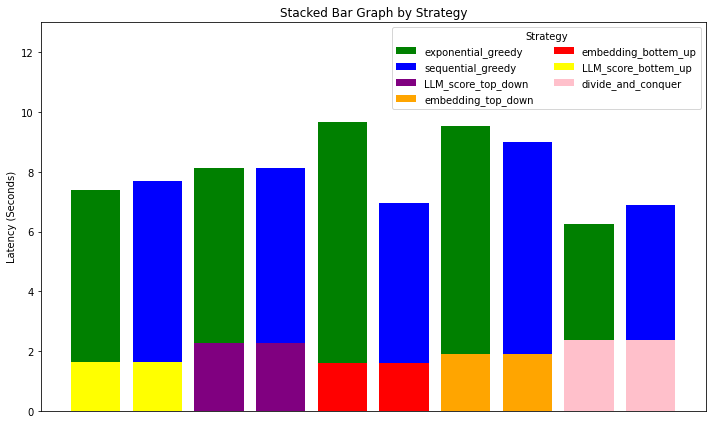

In [30]:
stack_bar(time_dict, cost_dict, 'latency', 'Latency (Seconds)',0,13)

5081.509630969407


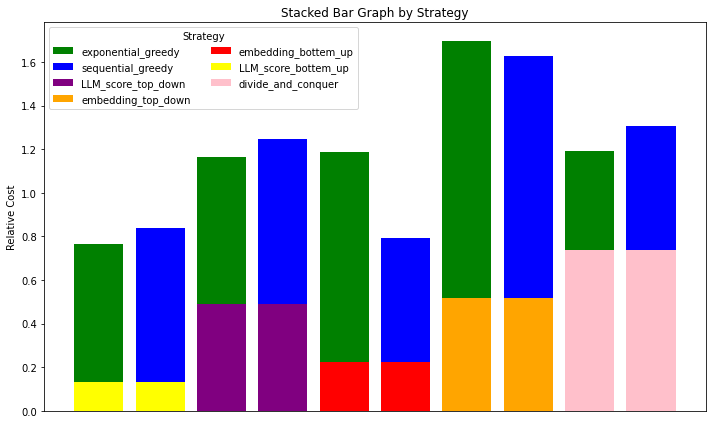

In [31]:
document_size = sum(document_size_dict.values()) / len(document_size_dict)
print(document_size)
cost_dict
relative_cost_dict = cost_dict.copy()

for strategy, cost in relative_cost_dict.items():
    relative_cost_dict[strategy] = cost/document_size 

stack_bar(time_dict, relative_cost_dict, 'cost', 'Relative Cost',-1,-1)




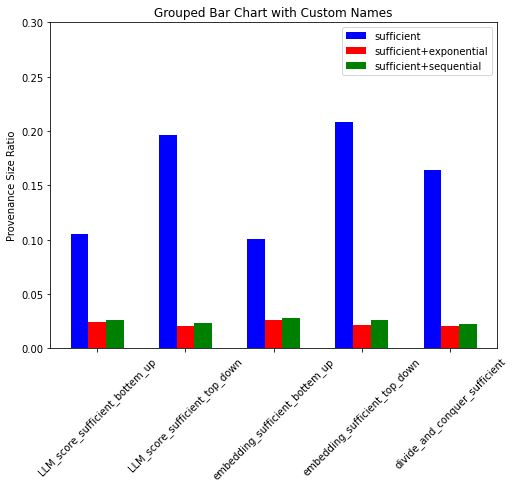

In [33]:
bar_provenance_ratio(size_ratio_dict,0,0.3)

- Bottem-up is better than top-down
  - 10% smaller sufficient provenance size 
  - 1.4X faster 
  - 25% tokens 
- Exponential vs sequential
  - Exponential is a winner in for most sufficient strategies 
    - 55% tokens for LLM_score_bottem up, to 94% tokens for embedding sufficient bottem up
- Sufficient vs Minimal
  - Provenance size/document size 
    - 10% - 21% size reduction for sufficient
    - ~3% size reduction for minimal
  - Latency
    - Sufficient: ~3 seconds
    - Sufficient + Minimal: 12 - 23 seconds
    - Winners: **Divide_conquer + exponential** and **embedding_bottem_up + sequential** (12 seconds)
  - Cost 
    - Sufficient: 0.2X - 1.2X tokens relative to doc size 
    - Sufficient + Minimal: 1.6X - 3.2X tokens relative to doc size 
    - Winners: **embedding_bottem_up + sequential** (1.6X)

In [66]:
#hotpot 
model_name = 'gpt4omini'
dataset = 'hotpotQA'
sufficient_provenance_strategy_pool = ['LLM_score_sufficient_bottem_up','LLM_score_sufficient_top_down', 'embedding_sufficient_bottem_up','embedding_sufficient_top_down', 'divide_and_conquer_sufficient']
minimal_provenance_strategy_pool = ['null','exponential_greedy','sequential_greedy']

data_path = parent_directory + '/data/hotpotQA_fullwiki.json'
result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/' + model_name + '/eval' + '/' + dataset+ '/results_minimal/'

size_ratios, provenance_size_dict, size_ratio_dict, time_dict, cost_dict, document_size_dict, time_distribution, cost_distribution, sufficient_provenance_sentence_sizes, minimal_provenance_sentence_sizes = get_aggregate_results(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, data_path, result_folder_path,dataset, vanilla_ratio=1)

    
                

    
                

LLM_score_sufficient_bottem_up_null
provenance_size, size_ratio: 265.16083916083915 0.23090560392891496
time: 1.4153014421463013
tokens: 352.6993006993007 4.856643356643357

LLM_score_sufficient_bottem_up_exponential_greedy
provenance_size, size_ratio: 78.5 0.06970683623741271
time: 4.335954027590544
tokens: 1540.7434782608696 26.869565217391305

LLM_score_sufficient_bottem_up_sequential_greedy
provenance_size, size_ratio: 84.17948717948718 0.07456479177961688
time: 4.6725299256479635
tokens: 1719.91452991453 30.918803418803417

LLM_score_sufficient_top_down_null
provenance_size, size_ratio: 348.31481481481484 0.29476059449781594
time: 1.7444683233896892
tokens: 922.6407407407407 7.92962962962963

LLM_score_sufficient_top_down_exponential_greedy
provenance_size, size_ratio: 86.27848101265823 0.07628594071435657
time: 5.317291680267592
tokens: 2942.7679324894516 34.62447257383966

LLM_score_sufficient_top_down_sequential_greedy
provenance_size, size_ratio: 94.92340425531916 0.0852395688

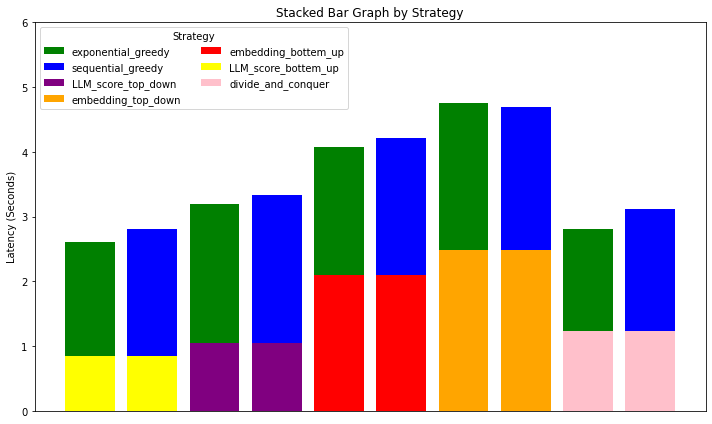

In [36]:
stack_bar(time_dict, cost_dict, 'latency', 'Latency (Seconds)',0,6)

1233.1704495137187


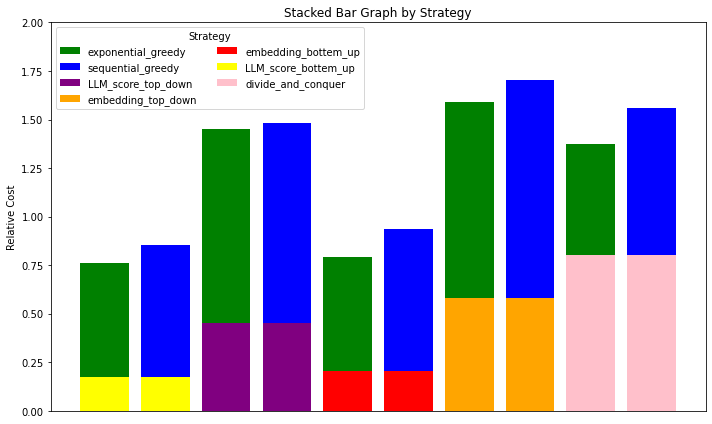

In [38]:
document_size = sum(document_size_dict.values()) / len(document_size_dict)
print(document_size)
cost_dict
relative_cost_dict = cost_dict.copy()

for strategy, cost in relative_cost_dict.items():
    relative_cost_dict[strategy] = cost/document_size 

stack_bar(time_dict, relative_cost_dict, 'cost', 'Relative Cost',0,2)




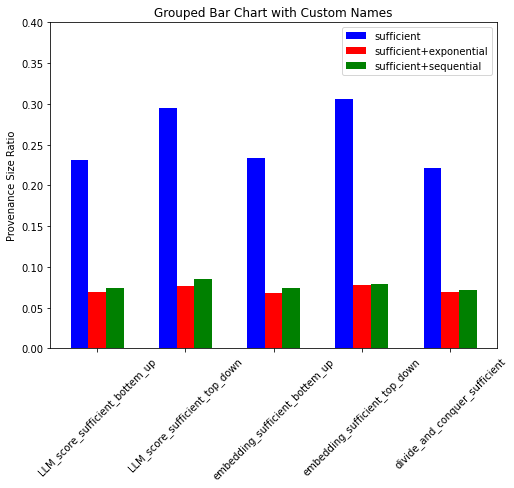

In [39]:
bar_provenance_ratio(size_ratio_dict,0,0.4)

- Bottem-up is better than top-down
  - 8% smaller sufficient provenance size 
  - 1.3X faster 
  - 34% tokens 
- Exponential vs sequential
  - Exponential is a winner in for most sufficient strategies 
    - 55% tokens for LLM_score_bottem up, to 94% tokens for embedding sufficient bottem up
- Sufficient vs Minimal
  - Provenance size/document size 
    - 22% - 31% size reduction for sufficient
    - ~7% size reduction for minimal
  - Latency
    - Sufficient: 1-3 seconds
    - Sufficient + Minimal: 4 - 8 seconds
    - Winners: **Divide_conquer** and **LLM_score** (4 seconds)
  - Cost 
    - Sufficient: 0.2X - 1.2X tokens relative to doc size 
    - Sufficient + Minimal: 1.6X - 3.5X tokens relative to doc size 
    - Winners: **embedding_bottem_up** and **LLM_score_bottem_up** (1.5X)